Filter

In [374]:
import pandas as pd
import yfinance as yf
import numpy as np
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas.tseries.offsets import MonthEnd
from scipy.optimize import curve_fit


In [375]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol.tolist()
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[1]
print(tickers)
print(len(tickers))

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADM', 'ADBE', 'ADP', 'AES', 'AFL', 'A', 'ABNB', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CM

In [376]:
# df.Date = pd.to_datetime(df.Date.Date)
# df = df[df.Date.Date >= '2023-06-01']
# added_tickers = df.Added.Ticker.tolist()

# # Now, filter the 'tickers' list
# tickers = [ticker for ticker in tickers if ticker not in added_tickers]
# tickers
# print(len(tickers))

In [377]:
# # Original list of tickers (before filtering out the added ones)
# original_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol.tolist()

# # Fetching the DataFrame containing added and removed companies
# df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[1]

# # Convert the 'Date' column to datetime
# df.Date = pd.to_datetime(df.Date.Date)

# # Filter the DataFrame for changes since June 1, 2023
# df = df[df.Date.Date >= '2023-06-01']

# # List of tickers added after June 1, 2023
# added_tickers = df.Added.Ticker.tolist()

# # Filter the original list to remove the added tickers
# current_tickers = [ticker for ticker in original_tickers if ticker not in added_tickers]

# # The removed tickers are those in the original list but not in the current list
# removed_tickers = set(original_tickers) - set(current_tickers)

# print("Tickers removed after 2023-06-01:", removed_tickers)
# print("Number of tickers removed:", len(removed_tickers))


In [378]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

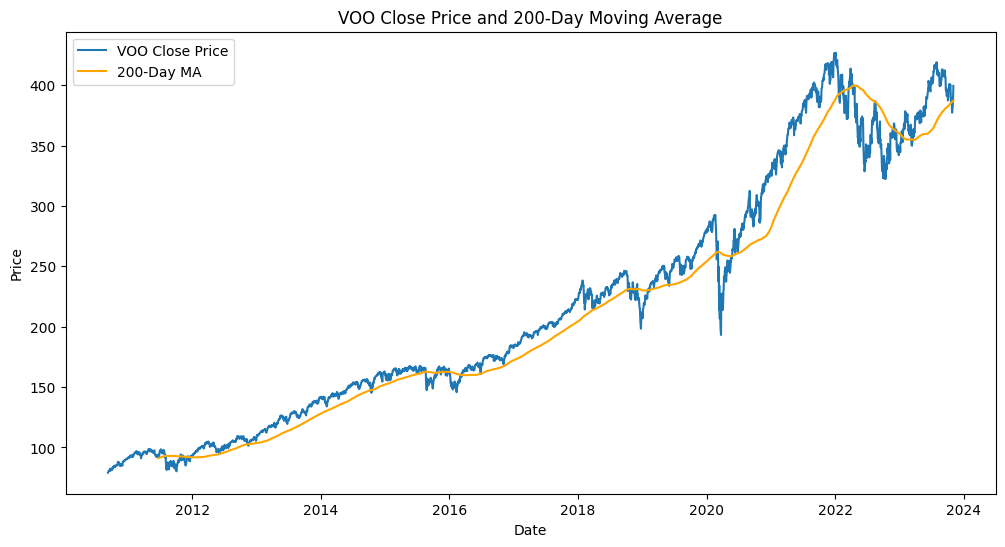

In [379]:
# Define the ticker symbol
tickerSymbol = 'VOO'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2023-11-04')
tickerDf['Date'] = tickerDf.index.date

import matplotlib.pyplot as plt

# Calculate the 200-day moving average
tickerDf['200MA'] = tickerDf['Close'].rolling(window=200).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tickerDf.index, tickerDf['Close'], label='VOO Close Price')
plt.plot(tickerDf.index, tickerDf['200MA'], label='200-Day MA', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('VOO Close Price and 200-Day Moving Average')
plt.legend()

# Show the plot
plt.show()

In [380]:

# def exp_regression(x, a, b):
#     return a * np.exp(b * x)

In [400]:
import numpy as np
import yfinance as yf
from scipy.stats import linregress
from arch import arch_model


def process_ticker(ticker):
    # Fetch historical data for the ticker
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2022-01-01', end='2023-11-01')

    # Calculate the natural logarithm of the closing prices
    tickerDf['Ln_Close'] = np.log(tickerDf['Close'])

    # Initialize lists to hold the slopes and other calculations
    exp_reg = []
    r_squared_values = []

    # Calculate the rolling 90-day exponential regression slope
    for end_day in range(91, len(tickerDf)):
        # Get the last 90 days up to the current date
        period = tickerDf.iloc[end_day-91:end_day]
        x = np.arange(len(period))
        y = period['Ln_Close']

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # Store the daily slope and r_squared value
        exp_reg.append(slope)
        r_squared_values.append(r_value**2)

    log_returns = 100 * tickerDf['Ln_Close'].pct_change().dropna()
    model = arch_model(log_returns, vol='Garch', p=1, q=1)
    model_fit = model.fit(update_freq=5, disp='off')
    tickerDf['GARCH_Volatility'] = model_fit.conditional_volatility

    # Pad the lists with Nones for the days without a 90-day window
    exp_reg = [None] * 91 + exp_reg
    r_squared_values = [None] * 91 + r_squared_values

    # Calculate the annualized exponential regression slope and adjusted slope
    annualized_exp_reg = [(np.exp(slope * 252) - 1) if slope is not None else None for slope in exp_reg]
    adjusted_slope = [annualized * r_squared if annualized is not None and r_squared is not None else None for annualized, r_squared in zip(annualized_exp_reg, r_squared_values)]

    # Assign the calculated values to the DataFrame
    tickerDf['Exp_Reg'] = exp_reg
    tickerDf['Annualized_Exp_Reg'] = annualized_exp_reg
    tickerDf['R_squared'] = r_squared_values
    tickerDf['Adjusted_Slope'] = adjusted_slope

    # Calculate the 100-day moving average
    tickerDf['100d_MA'] = tickerDf['Close'].rolling(window=100).mean()

    # Reset index and clean the DataFrame
    tickerDf.reset_index(inplace=True)
    tickerDf_cleaned = tickerDf.dropna(subset=['Exp_Reg'])

    return tickerDf_cleaned

# Process each ticker
apple_df = process_ticker('AAPL')
tesla_df = process_ticker('TSLA')
amzn_df = process_ticker('AMZN')
nvda_df = process_ticker('NVDA')
amd_df = process_ticker('AMD')
lulu_df = process_ticker('LULU')
msft_df = process_ticker('MSFT')
qcom_df = process_ticker('QCOM')
nvr_df = process_ticker('NVR')
bkng_df = process_ticker('BKNG')
mtd_df = process_ticker('MTD')


# Print the resulting DataFrames with the 100-day MA
print("Apple DataFrame:")
print(apple_df[['Date', 'Close','Ln_Close', 'Exp_Reg', 'Annualized_Exp_Reg', 'R_squared', 'Adjusted_Slope', 'GARCH_Volatility']])

print("\nTesla DataFrame:")
print(tesla_df[['Date', 'Close', 'Ln_Close', 'Exp_Reg', 'Annualized_Exp_Reg', 'R_squared', 'Adjusted_Slope', 'GARCH_Volatility']])

print("\nAmazon DataFrame:")
print(amzn_df[['Date', 'Close', 'Ln_Close', 'Exp_Reg', 'Annualized_Exp_Reg', 'R_squared', 'Adjusted_Slope', 'GARCH_Volatility']])

print("\nNVIDIA DataFrame:")
print(nvda_df[['Date', 'Close', 'Ln_Close', 'Exp_Reg', 'Annualized_Exp_Reg', 'R_squared', 'Adjusted_Slope', 'GARCH_Volatility']])

print("\nAMD DataFrame:")
print(amd_df[['Date', 'Close', 'Ln_Close', 'Exp_Reg', 'Annualized_Exp_Reg', 'R_squared', 'Adjusted_Slope', 'GARCH_Volatility']])


c:\Users\aaron\OneDrive\Desktop\markov\markov\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05236. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


c:\Users\aaron\OneDrive\Desktop\markov\markov\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08706. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Apple DataFrame:
                         Date       Close  Ln_Close   Exp_Reg  \
91  2022-05-13 00:00:00-04:00  145.847443  4.982561 -0.000814   
92  2022-05-16 00:00:00-04:00  144.290894  4.971831 -0.000835   
93  2022-05-17 00:00:00-04:00  147.959152  4.996936 -0.000871   
94  2022-05-18 00:00:00-04:00  139.611420  4.938863 -0.000905   
95  2022-05-19 00:00:00-04:00  136.171204  4.913913 -0.000990   
..                        ...         ...       ...       ...   
455 2023-10-25 00:00:00-04:00  170.874893  5.140932 -0.001140   
456 2023-10-26 00:00:00-04:00  166.670425  5.116018 -0.001172   
457 2023-10-27 00:00:00-04:00  167.998672  5.123956 -0.001224   
458 2023-10-30 00:00:00-04:00  170.065933  5.136186 -0.001268   
459 2023-10-31 00:00:00-04:00  170.545319  5.139001 -0.001307   

     Annualized_Exp_Reg  R_squared  Adjusted_Slope  GARCH_Volatility  
91            -0.185372   0.209065       -0.038755          0.516809  
92            -0.189840   0.213631       -0.040556          

c:\Users\aaron\OneDrive\Desktop\markov\markov\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [393]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import linregress

tickers = ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADM', 'ADBE', 'ADP', 'AES', 'AFL', 'A', 'ABNB', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DIS', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DTE', 'DUK', 'DD', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'LLY', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'EG', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FICO', 'FAST', 'FRT', 'FDX', 'FITB', 'FSLR', 'FE', 'FIS', 'FI', 'FLT', 'FMC', 'F', 'FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GEN', 'GNRC', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GL', 'GPN', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB', 'HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'ILMN', 'INCY', 'IR', 'PODD', 'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV', 'IRM', 'JBHT', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RVTY', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SEE', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SNA', 'SEDG', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UDR', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VFC', 'VTRS', 'VICI', 'V', 'VMC', 'WAB', 'WBA', 'WMT', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WRK', 'WY', 'WHR', 'WMB', 'WTW', 'GWW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']


summary_df = pd.DataFrame()

for ticker in tickers:
    # Fetch historical data
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2022-01-01', end='2022-06-01')

    # Store the 'Date' column before resetting the index
    tickerDf.reset_index(inplace=True)
    tickerDf['Ln_Close'] = np.log(tickerDf['Close'])

    # Perform linear regression
    x = tickerDf.index
    y = tickerDf['Ln_Close']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate exponential regression values
    tickerDf['Exp_Reg'] = np.exp(intercept) * np.exp(slope * x)

    # Calculate R-squared and adjusted slope
    r_squared = r_value**2
    adjusted_slope = tickerDf['Exp_Reg'] * r_squared

    # Calculate total return
    start_price = tickerDf['Close'].iloc[0]
    end_price = tickerDf['Close'].iloc[-1]
    total_return = (end_price - start_price) / start_price * 100

    # Get the last row and create a new DataFrame for it
    last_row_data = tickerDf.iloc[-1].to_dict()
    last_row_df = pd.DataFrame([last_row_data])
    last_row_df['Ticker'] = ticker
    last_row_df['Total_Return'] = total_return
    last_row_df['R_squared'] = r_squared
    last_row_df['Adjusted_Slope'] = adjusted_slope.iloc[-1]

    # Append to the summary DataFrame
    summary_df = pd.concat([summary_df, last_row_df])

# Reset index of the summary DataFrame
summary_df.reset_index(drop=True, inplace=True)

# Sort the DataFrame by 'Adjusted_Slope' in descending order
summary_df.sort_values(by='Adjusted_Slope', ascending=False, inplace=True)

# Print the top 20 rows of the summary DataFrame
print(summary_df[['Ticker', 'Date', 'Close', 'Total_Return', 'R_squared', 'Adjusted_Slope']].head(20))
top_20_tickers = summary_df.head(20)['Ticker'].tolist()
print(top_20_tickers)

KeyboardInterrupt: 

In [ ]:
# Initialize a dictionary to store the returns
stock_returns = {}
start_date = '2022-06-01'
end_date = '2022-12-01'
for ticker in top_20_tickers:
    # Fetch historical data
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', 
    start=start_date, end=end_date)

    # Calculate total return
    start_price = tickerDf['Close'].iloc[0]
    end_price = tickerDf['Close'].iloc[-1]
    total_return = (end_price - start_price) / start_price * 100

    # Store the return in the dictionary
    stock_returns[ticker] = total_return

    print(f"{ticker}: Total Return = {total_return:.2f}%")


NVR: Total Return = 5.73%
MTD: Total Return = 16.32%
BKNG: Total Return = -7.11%
BLK: Total Return = 9.99%
ELV: Total Return = 7.32%
BIO: Total Return = -21.43%
CHTR: Total Return = -21.01%
LRCX: Total Return = -5.93%
ADBE: Total Return = -17.51%
MCK: Total Return = 18.80%
NOC: Total Return = 15.66%
POOL: Total Return = -15.69%
INTU: Total Return = 0.16%
LMT: Total Return = 11.87%
MSCI: Total Return = 18.31%
DPZ: Total Return = 8.38%
TYL: Total Return = -0.90%
ZBRA: Total Return = -19.21%
CMG: Total Return = 18.35%
REGN: Total Return = 14.08%


In [ ]:
import pandas as pd

# Initial investment and allocation
initial_investment = 1000
allocation_per_stock = initial_investment / len(stock_returns)

# Calculate the value of each stock after the return
final_values = {ticker: allocation_per_stock * (1 + ret / 100) for ticker, ret in stock_returns.items()}

# Total portfolio value at the end
total_portfolio_value = sum(final_values.values())

# Total portfolio return
total_portfolio_return = (total_portfolio_value - initial_investment) / initial_investment * 100

# Calculate the number of years for CAGR calculation
start_date = start_date
end_date = end_date
years = pd.to_datetime(end_date) - pd.to_datetime(start_date)
years = years.days / 365.25

# Calculate CAGR for the portfolio
portfolio_cagr = ((total_portfolio_value / initial_investment) ** (1 / years)) - 1

# Fetch SPY data
spy_data = yf.Ticker("SPY").history(start=start_date, end=end_date)
spy_start_price = spy_data['Close'].iloc[0]
spy_end_price = spy_data['Close'].iloc[-1]

# Calculate SPY total return
spy_total_return = (spy_end_price - spy_start_price) / spy_start_price * 100

# Calculate SPY CAGR
spy_cagr = ((spy_end_price / spy_start_price) ** (1 / years)) - 1

# Summary DataFrame
summary = pd.DataFrame({
    "Metric": ["Total Return", "CAGR"],
    "Portfolio": [total_portfolio_return, portfolio_cagr],
    "SPY": [spy_total_return, spy_cagr]
})

print(summary)


         Metric  Portfolio       SPY
0  Total Return   1.808619  0.374264
1          CAGR   0.036423  0.007484


In [ ]:
def generate_buy_signals(ticker_df, tolerance=0.005):
    buy_signals = []
    
    for i in range(len(ticker_df)):
        # Conditions: R_squared and Adjusted Slope near 0
        if abs(ticker_df.iloc[i]['R_squared']) <= tolerance and abs(ticker_df.iloc[i]['Adjusted_Slope']) <= tolerance:
            # Check if the current price is above the 100-day MA
            if ticker_df.iloc[i]['Close'] > ticker_df.iloc[i]['100d_MA']:
                buy_signals.append(ticker_df.iloc[i]['Date'])
    
    return buy_signals

# Example usage
apple_buy_signals = generate_buy_signals(apple_df)
print("AAPL Buy Signals:", apple_buy_signals)


AAPL Buy Signals: [Timestamp('2022-08-18 00:00:00-0400', tz='America/New_York'), Timestamp('2022-08-19 00:00:00-0400', tz='America/New_York'), Timestamp('2022-10-28 00:00:00-0400', tz='America/New_York'), Timestamp('2022-10-31 00:00:00-0400', tz='America/New_York')]


In [401]:
def create_plots(ticker_df, ticker_name):
    buy_signals = generate_buy_signals(ticker_df)

    # Create subplots
    fig = make_subplots(rows=5, cols=1, subplot_titles=(f"{ticker_name} Closing Prices", "90-Day Exponential Regression Slope", "R Squared", "Adjusted Slope"))
    for date in buy_signals:
        buy_signal_price = ticker_df[ticker_df['Date'] == date]['Close'].values[0]
        fig.add_trace(go.Scatter(x=[date], y=[buy_signal_price], mode='markers', name='Buy Signal', marker=dict(color='green', size=10)), row=1, col=1)

    # Add the closing prices plot
    fig.add_trace(go.Scatter(x=ticker_df['Date'], y=ticker_df['Close'], name='Close', mode='lines'), row=1, col=1)
    fig.add_trace(go.Scatter(x=ticker_df['Date'], y=ticker_df['100d_MA'], name='100d MA', mode='lines', line=dict(color='orange')), row=1, col=1)

    # Add the exponential regression slope plot
    fig.add_trace(go.Scatter(x=ticker_df['Date'], y=ticker_df['Exp_Reg'], name='Exp Reg Slope', mode='lines'), row=2, col=1)

    # Add the R squared plot
    fig.add_trace(go.Scatter(x=ticker_df['Date'], y=ticker_df['R_squared'], name='R Squared', mode='lines'), row=3, col=1)

    # Add the adjusted slope plot
    fig.add_trace(go.Scatter(x=ticker_df['Date'], y=ticker_df['Adjusted_Slope'], name='Adjusted Slope', mode='lines'), row=4, col=1)

    fig.add_trace(go.Scatter(x=ticker_df['Date'], y=ticker_df['GARCH_Volatility'], name='Adjusted Slope', mode='lines'), row=5, col=1)

    # Update layout
    fig.update_layout(height=800, title=f'{ticker_name} Stock Analysis', showlegend=False)
    fig.update_xaxes(title_text="Date", row=4, col=1)
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="Exp Reg Slope", row=2, col=1)
    fig.update_yaxes(title_text="R Squared", row=3, col=1)
    fig.update_yaxes(title_text="Adjusted Slope", row=4, col=1)

    # Show the plot
    fig.show()

# Create and show plots for AAPL and TSLA
create_plots(apple_df, 'AAPL')
create_plots(tesla_df, 'TSLA')
create_plots(amzn_df, 'AMZN')
create_plots(nvda_df, 'NVDA')
create_plots(amd_df, 'AMD')
create_plots(lulu_df, 'LULU')
create_plots(msft_df, 'MSFT')
create_plots(bkng_df, 'BKNG')
create_plots(nvr_df, 'NVR')
create_plots(mtd_df, 'MTD')